# MaxCut problem definition


*MaxCut* consist of partitioning a graph's vertices into two different sets. The goal of this partitioning is to maximize the number of cuts necessary to separate these two sets. In other words, *MaxCut* tries to maximize the number of edges shared between the two sets.

*MaxCut*is considered an NP-Complete problem which means that the cost to solving this algorithm classically grows exponentially with the number of nodes in the graph. 

To demonstrate the *MaxCut* problem we need to first define a graph.

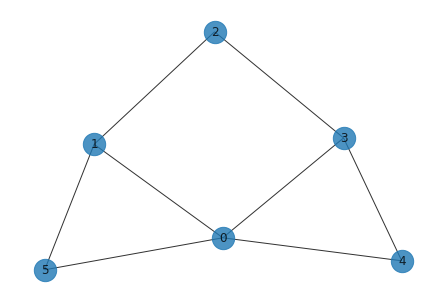

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3, 4, 5])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (3, 4), (4, 0), (5,1), (5,0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)


an example of the colored indices can be seen bellow:

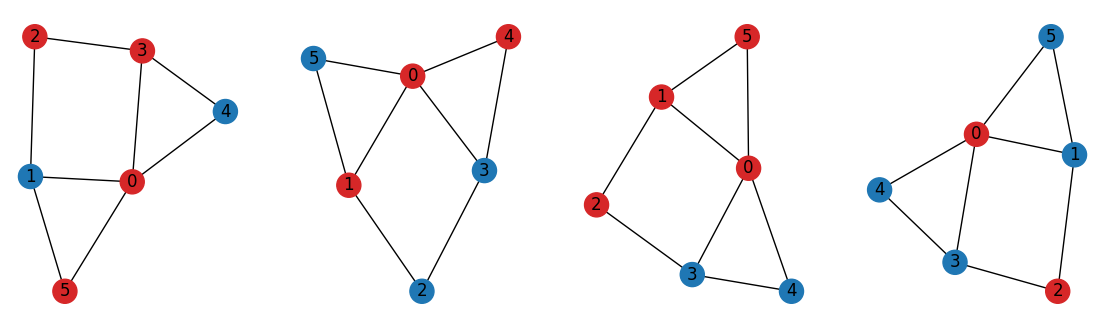

In [3]:
def color_graph(graph, bitstring: str, ax=None):
    '''
        color the vertices of a graph with blue and red corresponding to the '0's and '1's specified in the bit-string respectively.

        args:
            graph: graph 
                A network graph

            bitstring: bit-string 
                    a bit-string defining the colors of each of the vertices

            ax: Matplotlib Axes object, optional
                Draw the graph in specified Matplotlib axes.
    '''

    color_map = []
    for b in list(bitstring):
        color_map.append("tab:blue" if b == '0' else "tab:red")
    
    nx.draw(graph, node_color=color_map, with_labels=True, ax=ax)
    
        


num_graphs = 4
fig, ax = plt.subplots(ncols=num_graphs, figsize=(14, 4))

bitstrings = ["101101", "110010", "111001", "101000"]
for i in range(num_graphs):
    color_graph(graph, bitstrings[i], ax=ax[i])

plt.show()


The goal is to find the optimal bit-string that would maximize the number of edges connecting the red and blue nodes. 

The goal is to find the optimal bit-string that would maximize the number of edges connecting the red and blue nodes. 

For the *MaxCut* problem we can define the following cost function:

$$C = \sum_{i,j=1}^{N} w_{ij}$$

where N is the total number of nodes, and $w_ij$ is defined as the following: 

$$ 
w_{ij} = \begin{cases} 
            1 & \text{if nodes $i$ and $j$ are connected and they are from different sets} \\
            0 & \text{otherwise}
         \end{cases}
$$


# Solving the problem using QAOA


We can map this cost function into a problem Hamiltonian that we can use to run the QAOA algorithm. This Hamiltonian can be written as:

$$
H_c = \frac{1}{2} \sum_{<i,j>}(1- \sigma^{Z}_{i} \sigma^{Z}_{j})
$$

where $<i,j>$ is the set of edges connecting nodes $i$ and $j$. Moreover, $\sigma_{i}^{Z}$ is the Pauli z operator applied on qubit $i$. 

This means that the first layer of the QAOA would be:
$$
U(H_c, \gamma) = e^{-i \gamma H_c}
$$

The mixer Hamiltonian used for this problem can simply be:
$$H_b =  \sum_{i=1}^{N} \sigma^{X}_{i} $$

With a the following corresponding unitary operator:
$$
U(H_b, \beta) = e^{-i \beta H_b}.
$$





We can define these two Hamiltonian using Qibo's ``hamiltonians.SymbolicHamiltonian`` module like this:

In [4]:
from qibo.symbols import Z, X
from qibo import hamiltonians

def build_maxcut_hamiltonian(graph):
    '''
    build the MaxCut hamiltonian of a given graph. this takes into account all the edges of the graph.

    args: 
        graph: graph 
            A network graph
    
    returns:
        The cost hamiltonian of the given graph

    '''

    # definition of the symbolic hamiltonian using Qibo symbols
    sham = 1/2 * sum((1 - Z(i) * Z(j)) for i, j in graph.edges()) 
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_mixer_hamiltonian(graph):
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    sham = sum((X(i)) for i in range(graph.number_of_nodes() )) 
    
    return hamiltonians.SymbolicHamiltonian(sham)


Construct the QAOA variational circuit and optimize it:

In [5]:
import numpy as np
from qibo import models, hamiltonians

# create the cost Hamiltonian for the given graph
hamiltonian = build_maxcut_hamiltonian(graph)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(graph)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with four layers 
initial_parameters = 0.01 * np.random.random(4)

# run the QAOA optimization with the initial parameters and the hamiltonians defined 
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, method="BFGS")

print("best energy: ", best_energy)

[Qibo 0.1.11|INFO|2023-04-21 10:32:42]: Using numpy backend on /CPU:0


best energy:  -5.609304054652293


Get the optimal bit-string generated by QAOA:

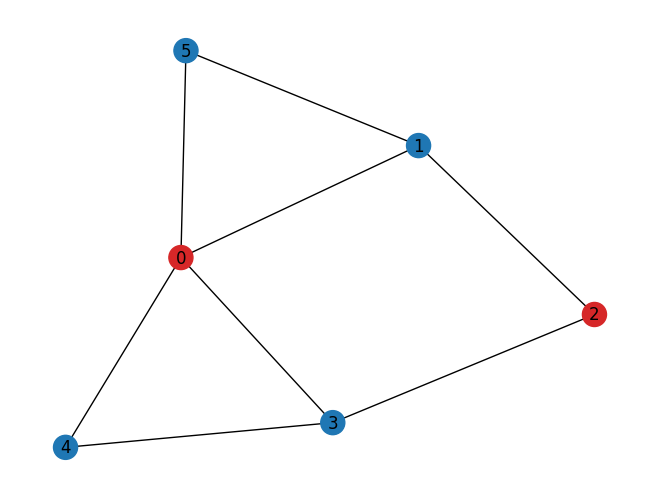

In [6]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

nqubits = graph.number_of_nodes()

# build the circuit using the optimal parameters optimized by QAOA

qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(None)

# measure the output of the circuit and obtain results 
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit,
                       quantum_state, nshots=4000)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)


qaoa_solution = ordered_freq_counter[0][0]
color_graph(graph, qaoa_solution)


Compare the results of QAOA to the optimal solution obtained using a classical Brute-force minimization:

number of cuts in the QAOA solution:  6
number of cuts in the Brute-force solution:  6


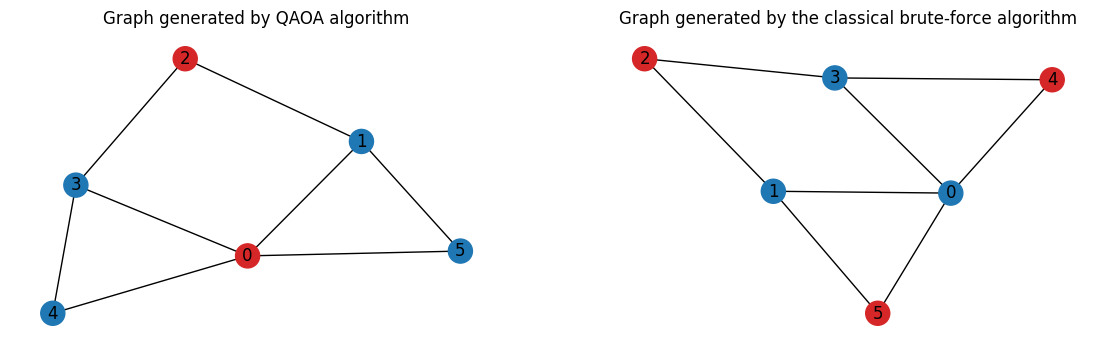

In [7]:
def num_cuts(x:str, graph):
    '''
    compute the number of cuts that the sets defined by bit-string x would have in the graph

    args: 
        x: bit-string
        bit-string defining the two sets with the values '0's and '1's

        graph: graph
        a network graph

    '''
    obj = 0
    for i, j in graph.edges():
        if x[i] != x[j]:
            obj += 1
    return obj


noptions = 2**graph.number_of_nodes() # this scales exponentially with the number of nodes in the graph 
solution = ''
ncuts = 0

for i in range(noptions):
    x = np.binary_repr(i, nqubits)
    aux_cuts= num_cuts(str(x),graph)
    if aux_cuts > ncuts:
        ncuts = aux_cuts
        solution = str(x)


print("number of cuts in the QAOA solution: ", num_cuts(qaoa_solution, graph))
print("number of cuts in the Brute-force solution: ", num_cuts(solution, graph))


num_graphs = 2
fig, ax = plt.subplots(ncols=num_graphs, figsize=(14, 4))


color_graph(graph, qaoa_solution, ax=ax[0])
color_graph(graph, solution, ax=ax[1])

ax[0].set_title("Graph generated by QAOA algorithm")
ax[1].set_title("Graph generated by the classical brute-force algorithm")

plt.show()


# Solving the problem using Adiabatic Quantum Optimization

For the Adiabatic Quantum Optimization (AQO) we use the same cost hamiltonian that we used for QAOA as our target hamiltonian
$$
H_1 = -\frac{1}{2} \sum_{<i,j>} \sigma^{Z}_{i} \sigma^{Z}_{j}.
$$
On the other hand, our initial Hamiltonian has to be simple, so that we know its ground state and we can easily prepare it. In this case we use the following Hamiltonian as our initial Hamiltonian :
$$
 H_0 = \sum_{i=0}^{N} \sigma^{X}_{i}.
$$


In [10]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian


# build initial (H0) and target (H1) hamiltonians
H0 = build_mixer_hamiltonian(graph)
H1 = build_maxcut_hamiltonian(graph)

dt = 0.1
nqubits = graph.number_of_nodes()

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.calculate_dense().matrix)
H0_dense = Hamiltonian(nqubits, H0.calculate_dense().matrix)

# define scheduling method
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

the solution is:  101011
number of cuts:  6


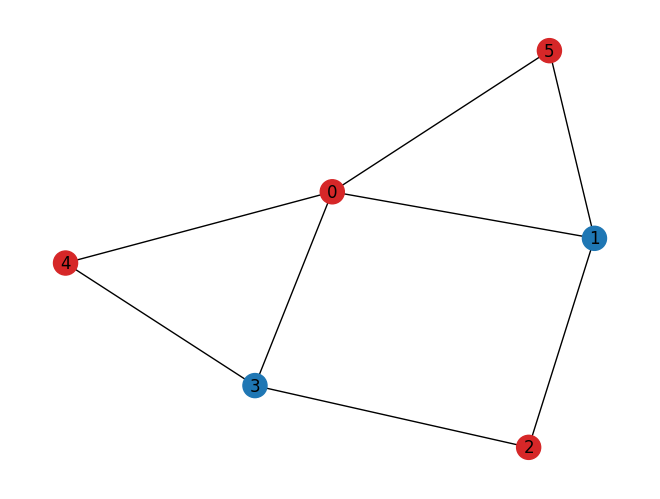

In [30]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=20)

# obtain the state with the highest probability
solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)


print("the solution is: ", adiabatic_solution)
print("number of cuts: ", num_cuts(adiabatic_solution, graph))

color_graph(graph, adiabatic_solution)
